# Homework 3, Question 2: Quantum Phase Estimation

Implement the phase-estimation circuit to find the eigenvalue associated with eigenvector 

$|u\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle)$

of the unitary matrix 

$\hat{U}_Y = \begin{bmatrix} 1 & -i \\ i & 1 \end{bmatrix}$

(Hint: Two-bit precision will be enough for the purpose of this task!)

In [1]:
## Imports

import argparse
import math
import matplotlib.pyplot as plt
from qiskit import  ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2 as FakeProvider
from qiskit.circuit.library import QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [2]:
## Input
operator = "Z"     # "Z", "Y" or "RX"
theta = math.pi/2  # angle for RX operator
eigenvector = "e0" # "e0 or "e1"
bits = 2
provider = "aer"
shots = 1024

In [3]:
## Initialize
input_qubit = 0
n = bits

qubits = QuantumRegister(n+1, "q")
clbits = ClassicalRegister(n, "c")
circuit = QuantumCircuit(qubits, clbits)

In [4]:
## Build circuit

# Input state
if operator == "Z":
    if eigenvector == "e0":
        circuit.x(input_qubit)
elif operator == "Y":
    if eigenvector == "e0":
        circuit.rx(math.pi/2, input_qubit)
    else:
        circuit.rx(-math.pi/2, input_qubit)
else:
    if eigenvector == "e0":
        circuit.ry(math.pi/2, input_qubit)
    else:
        circuit.ry(-math.pi/2, input_qubit)

# Prepare input for QFT:
for i in range(n):
    circuit.h(i+1)
for i in range(n):
    if operator == "Z" and i % 2 == 1:
        circuit.cz(n-i, input_qubit)
    elif operator == "Y" and i % 2 == 1:
        circuit.cy(n-i, input_qubit)
    elif operator == "RX":
        circuit.crx(theta*(2**(n-i-1)), n-i, input_qubit)

# QFT:
circuit.append(QFT(n).inverse(), qubits[1:])

# Measure:
circuit.measure(qubits[1:], clbits)

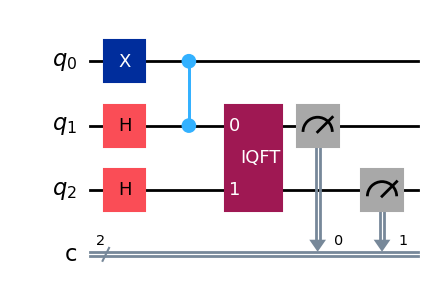

In [5]:

## Diagram
circuit.draw(output="mpl")

10: 1024


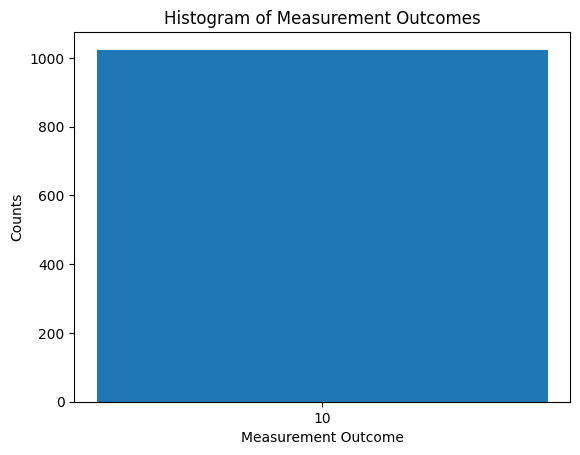

In [6]:
## Run
backend = AerSimulator()
sampler = Sampler(backend)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
job = sampler.run([isa_circuit], shots=shots)
result = job.result()
counts = result[0].data.c.get_counts()
for k, v in counts.items():
    print(f"{k}: {v}")

# Generate histogram
plt.bar(counts.keys(), counts.values())
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Histogram of Measurement Outcomes')
plt.show()
